In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

In [2]:
# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [3]:
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

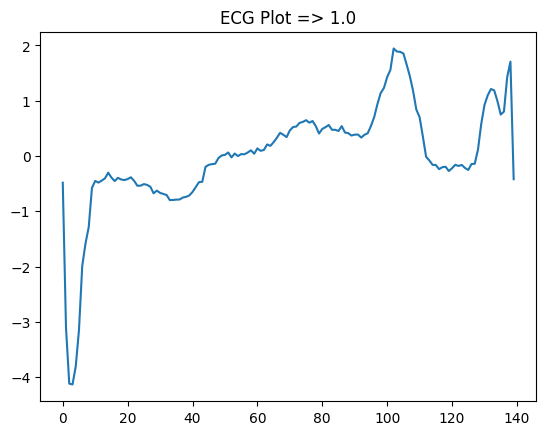

In [4]:
idx  = np.random.randint(5000)
plt.plot(data[idx])
plt.title(f"ECG Plot => {labels[idx]}")
plt.show()

In [5]:
regs = []
anoms = []
for i in range(4900):
    if labels[i] == 0:
        anoms.append(data[i])
    else:
        regs.append(data[i])

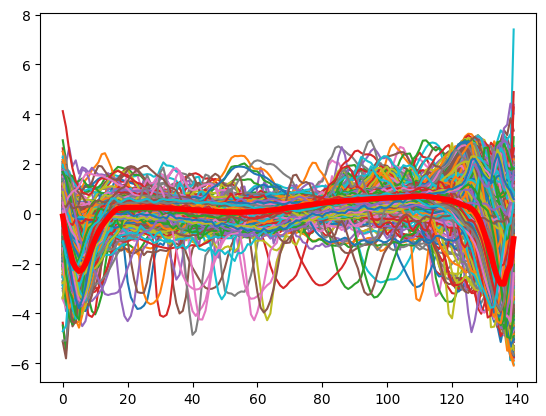

In [6]:
plt.plot(np.transpose(anoms))
plt.plot(np.mean(anoms,axis=0),linewidth=4, color='r')
plt.show()

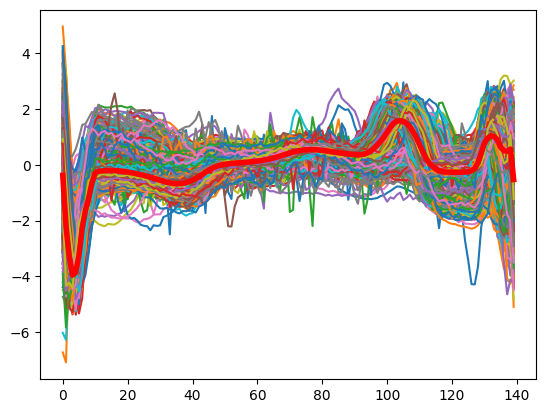

In [7]:
plt.plot(np.transpose(regs))
plt.plot(np.mean(regs,axis=0),linewidth=4, color='r')
plt.show()

In [8]:
mn_reg  = np.mean(regs,axis=0)
mn_anom = np.mean(anoms,axis=0)

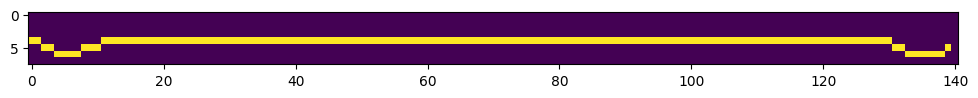

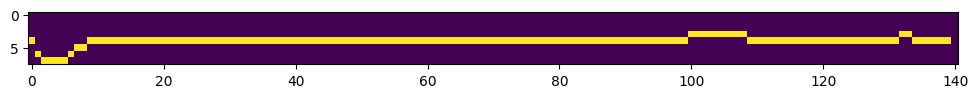

In [9]:
def convert_and_plot_signal(signal):
    input_signals = np.zeros((8,141))
    for t,val in enumerate(signal):
        rnd = 8 - (int(val) + 4)
        # print(rnd)
        rnd_idx = np.clip(rnd,0,7)
        input_signals[rnd_idx][t] = 1

    plt.figure(figsize=(12,12))
    plt.imshow(input_signals)
    plt.show()

convert_and_plot_signal(mn_anom)
convert_and_plot_signal(mn_reg)


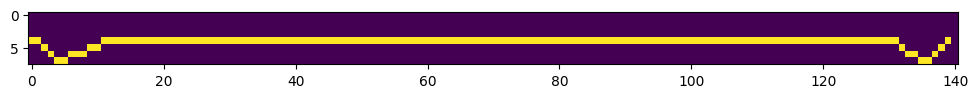

In [10]:
idx  = np.random.randint(5000)
convert_and_plot_signal(data[idx])

In [11]:
def make_ecg_dataset(raw_data):

    labels = raw_data[:, -1]
    data = raw_data[:, 0:-1]

    regs = []
    anoms = []

    reg_spikes  = []
    anom_spikes = []



    for i in range(len(labels)):

        signal = data[i]

        # input_spike_rows = np.zeros((8,141))
        input_spike_rows = [[] for _ in range(8)]
        for t,val in enumerate(signal):
            rnd = 8 - (int(val) + 4)
            # print(rnd)
            rnd_idx = np.clip(rnd,0,7)
            # input_spike_rows[rnd_idx][t] = 1
            if len(input_spike_rows[rnd_idx]) > 0:
                if t - input_spike_rows[rnd_idx][-1] > 35:
                    input_spike_rows[rnd_idx].append(t)
            else:
                input_spike_rows[rnd_idx].append(t)


        if labels[i] == 0:
            anoms.append(signal)
            reg_spikes.append(input_spike_rows)
        else:
            regs.append(signal)
            anom_spikes.append(input_spike_rows)

    print(f"Dataset with {len(reg_spikes)} regular ECG inputs and {len(anom_spikes)} anomalies generated.")
    return reg_spikes, anom_spikes

    
reg_spikes, anom_spikes = make_ecg_dataset(raw_data)
        

Dataset with 2079 regular ECG inputs and 2919 anomalies generated.


In [12]:
for row in reg_spikes[0]:
    print(row)

[]
[]
[]
[]
[0, 36, 72, 108]
[3, 131]
[5, 132]
[133]


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import time
import sys
sys.path.append('../')

from neuron import Neuron
from network import Network
import components

from weight_structures import *
from learning_rules import *
from plotting import *
from system_functions import *
from argparser import setup_argument_parser

[2, 2, 4, 8]


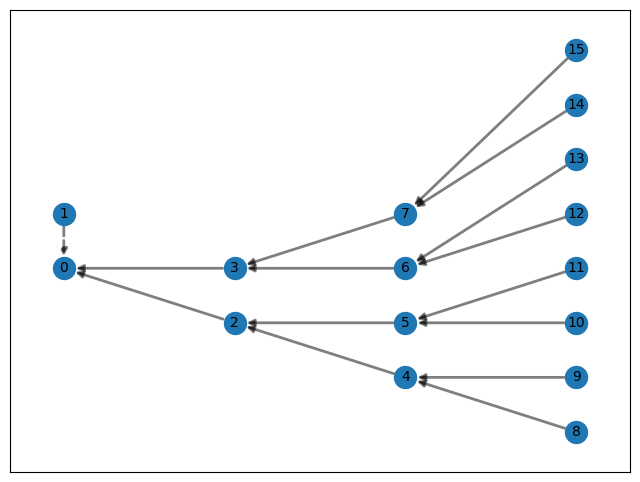

In [14]:
W = [
[np.ones((2,))],
np.ones((2,2)),
np.ones((4,2)),
]
neurons = []
for i in range(2):
    neuron = Neuron(
        name=f'node_{i}',
        threshold = 0.25,
        weights=W,
        )
    neuron.normalize_fanin_symmetric(fanin_factor=2)
    neurons.append(neuron)
    if i == 0:
        graph_adjacency(neuron.adjacency,neuron.get_dimensions())

In [15]:
def plot_trajectories(nodes,double_dends=False):
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    fig,ax = plt.subplots(len(nodes),1,figsize=(8,2.25*len(nodes)), sharex=True)
    for n,node in enumerate(nodes):

        ax[n].set_title(f"Update Trajectory of {node.name} Arbor",fontsize=12)
        for dend in node.dendrite_list:
            if hasattr(dend,'update_traj') and 'ref' not in dend.name:
                if isinstance(dend,components.Soma): 
                    lw = 4
                    c = colors[2]
                    line='solid'

                elif dend.loc[0]==1:
                    c = colors[3] 
                    lw = 2 
                    line = 'dashed'
                elif dend.loc[0]==3:
                    # print(dend.name, dend.outgoing[0][1])
                    if dend.outgoing[0][1] < 0:
                        c = 'r' 
                    else:
                        c = 'g'
                    lw = 2   
                    line = 'dotted'
                else:
                    c = colors[4]
                    lw = 1
                    line = 'dotted'

                ax[n].plot(np.array(dend.update_traj),linewidth=lw,linestyle=line,color=c,label=dend.name)

        # plt.legend(bbox_to_anchor=(1.01,1))
        # ax[n].set_x_label("Updates",fontsize=14)
        # ax[n].set_y_label("Flux Offset",fontsize=14)
    fig.tight_layout()
    plt.show()

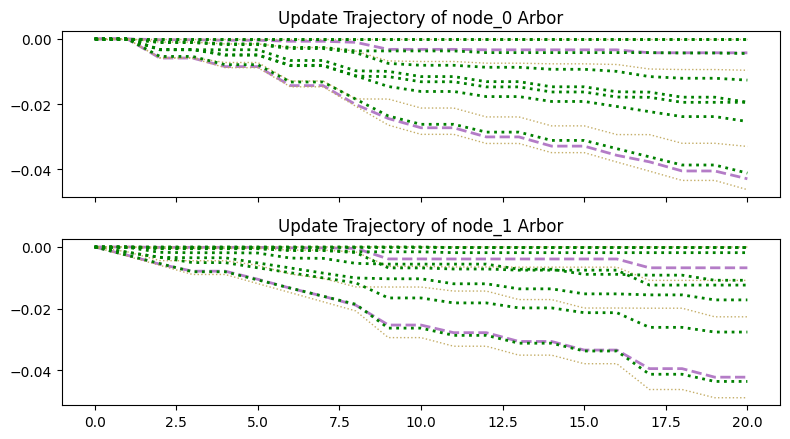

In [31]:
W = [
[np.ones((2,))],
np.ones((2,2)),
np.ones((4,2)),
]
neurons = []
for i in range(2):
    neuron = Neuron(
        name=f'node_{i}',
        threshold = 0.25,
        weights=W,
        )
    neuron.normalize_fanin_symmetric(fanin_factor=2)
    neurons.append(neuron)

train = 10
test  = 2
eta = 0.005
max_offset = 0.8
updater = 'classic'
runs = 1


def run_net(neurons,inpt,targets,duration=150,learn=True,plotting=False):
    for i,neu  in enumerate(neurons):
        neu.add_spike_rows(inpt)
    net = Network(
        run_simulation = True,
        nodes          = neurons,
        duration       = duration,
    )
    if plotting == True:
        plot_nodes(neurons)
        for n,neuron in enumerate(neurons):
            plot_by_layer(neuron,3,flux=False)
            # for d in neuron.dendrite_list:
            #     if d.loc[0]==3:
            #         plt.plot(d.flux)
            # plt.show()
    outputs = []
    for n,neuron in enumerate(neurons):
        output = len(neurons[n].dend_soma.spikes)
        outputs.append(output)
        error = targets[n] - outputs[n]
        if learn==True:
            make_update(neuron,error,eta,max_offset,updater)

    clear_net(net)
    return outputs

for run in range(runs):   
    success = 0 
    for trn in range(train):
        targets = [1,0]
        outputs = run_net(neurons,reg_spikes[trn],targets,plotting=False)
        if np.argmax(outputs)==np.argmax(targets): success+=1
        print(f"Run {run}  ::  {targets} -> {outputs}  :: {success}/{trn*2+1}",end="\r")


        targets = [0,1]
        outputs = run_net(neurons,anom_spikes[trn],targets,plotting=False)
        if np.argmax(outputs)==np.argmax(targets): success+=1
        print(f"Run {run}  ::  {targets} -> {outputs}  ::  {success}/{trn*2+2}",end="\r")


plot_trajectories(neurons)


In [32]:
success=0
seen = 0
test= 100
for tst in range(train,train+test):
    seen+=1
    targets = [1,0]
    outputs = run_net(neurons,reg_spikes[tst],targets,learn=False,plotting=False)
    if np.argmax(outputs)==np.argmax(targets): success+=1
    print(f"{targets} -> {outputs}  :: {success}/{seen}",end="\r")

    # plt.figure(figsize=(12,12))
    # plt.imshow(reg_spikes[tst])
    # plt.show()

    seen+=1
    targets = [0,1]
    outputs = run_net(neurons,anom_spikes[tst],targets,learn=False,plotting=False)
    if np.argmax(outputs)==np.argmax(targets): success+=1
    print(f"{targets} -> {outputs}  :: {success}/{seen}",end="\r")

    # plt.figure(figsize=(12,12))
    # plt.imshow(anom_spikes[tst])
    # plt.show()


In [44]:
W = [
[np.ones((2,))],
np.ones((2,2)),
np.ones((4,2)),
]

chunks = ['A','B','C','D']
labels = [0,1]

nodes = []
for chunk in chunks:
    for label in labels:
        
        neurons = []
        neuron = Neuron(
            name=f'node_{chunk}{label}',
            threshold = 0.25,
            weights=W,
            )
        neuron.normalize_fanin_symmetric(fanin_factor=2)
        nodes.append(neuron)
print(len(nodes))
print_attrs(nodes,['name'])

8


  node_A0  
  node_A1  
  node_B0  
  node_B1  
  node_C0  
  node_C1  
  node_D0  
  node_D1  




['node_A0',
 'node_A1',
 'node_B0',
 'node_B1',
 'node_C0',
 'node_C1',
 'node_D0',
 'node_D1']

In [45]:
def spikes_to_chunks(in_spikes,start,stop):
    chunk_spikes = [[] for _ in range(8)]
    for c,channel in enumerate(in_spikes):
        for spk in channel:
            if spk >= start and spk < stop:
                chunk_spikes[c].append(spk-start)
    return chunk_spikes

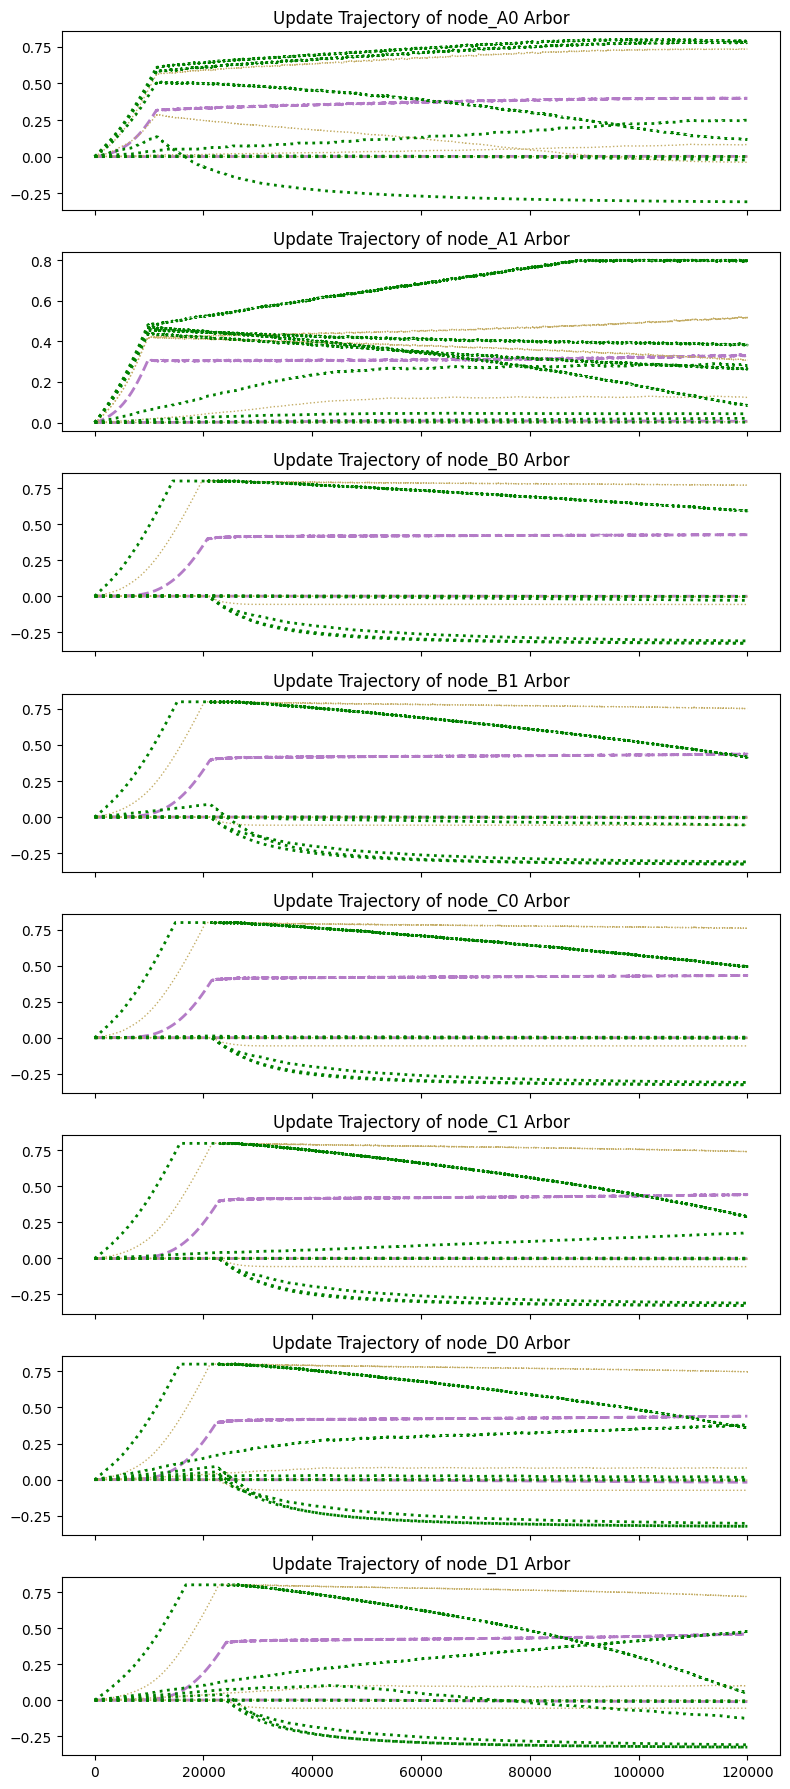

In [46]:
train = 1500
test  = 1
eta = 0.001
max_offset = 0.8
updater = 'classic'
duration = 140
runs = 10
window = int(duration/len(chunks))

for run in range(runs):   
    success = 0 
    for trn in range(train):


        for i, chunk in enumerate(chunks):

            start = i*window
            stop = i*window+window
        

            ### Regular ECG Signals ###
            in_spikes = reg_spikes[trn]
            chunk_spikes = spikes_to_chunks(in_spikes,start,stop)

            targets = np.zeros((8,))
            targets[i*2] = 1

            

            outputs = run_net(nodes,chunk_spikes,targets,duration=window,plotting=False)


            ### Anomolous ECG Signals ###
            in_spikes = anom_spikes[trn]
            chunk_spikes = spikes_to_chunks(in_spikes,start,stop)

            targets = np.zeros((8,))
            targets[i*2+1] = 1

            outputs = run_net(nodes,chunk_spikes,targets,duration=window,plotting=False)

            print(f"Run {run}  --  sample {trn}",end="\r")

plot_trajectories(nodes)



In [ ]:
def run_timing_test(nodes,inpt,duration,plotting=False):
    for i,neu  in enumerate(neurons):
        neu.add_spike_rows(inpt)
    net = Network(
        run_simulation = True,
        nodes          = nodes,
        duration       = duration,
    )
    if plotting == True:
        plot_nodes(neurons)
        for n,neuron in enumerate(neurons):
            plot_by_layer(neuron,3,flux=False)

    outputs = []
    for n,neuron in enumerate(neurons):
        output = len(neurons[n].dend_soma.spikes)
        outputs.append(output)

    clear_net(net)
    return outputs
    



  timing_node    150  
  timing_node_dend_ref    150  
  timing_node_dend_1_0_0    140  
  timing_node_dend_1_0_1    105  
  timing_node_dend_1_0_2    70  
  timing_node_dend_1_0_3    35  




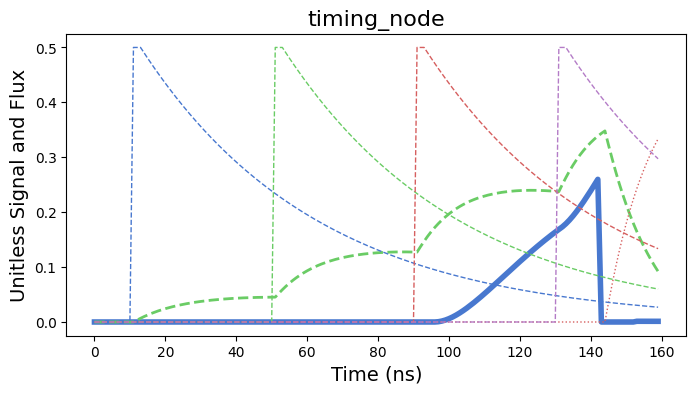

In [59]:
W_timing = [
    [[.1,.2,.3,.4]]
]

arbor_params = [
    [[{'tau':(4*35)},{'tau':(3*35)},{'tau':(2*35)},{'tau':(1*35)}]]
    ]

timing_neuron = Neuron(
    name=f'timing_node',
    threshold = 0.25,
    weights=W_timing,
    arbor_params=arbor_params
    )
neuron.normalize_fanin_symmetric(fanin_factor=2)

print_attrs(timing_neuron.dendrite_list,['name','tau'])

inpt = [
    [10],
    [50],
    [90],
    [130]
]
timing_neuron.add_spike_rows(inpt)
net = Network(
    run_simulation = True,
    nodes          = [timing_neuron],
    duration       = 160,
)
plot_nodes([timing_neuron],dendrites=True)

In [48]:


test  = 10
for tst in range(train,train+test):
    outputs = run_net(nodes,reg_spikes[tst],targets,learn=False,plotting=False)
    print(outputs)
    outputs = run_net(nodes,anom_spikes[tst],targets,learn=False,plotting=False)
    print(outputs)


    

[4, 5, 2, 2, 2, 2, 5, 6]
[4, 5, 2, 2, 2, 2, 5, 6]
[4, 5, 2, 2, 2, 2, 5, 6]
[4, 5, 2, 2, 2, 2, 5, 6]
[4, 5, 2, 2, 2, 2, 5, 6]
[4, 5, 2, 2, 2, 2, 5, 6]
[4, 5, 2, 2, 2, 2, 5, 6]
[4, 5, 2, 2, 2, 2, 5, 6]
[4, 5, 2, 2, 2, 2, 5, 6]
[4, 5, 2, 2, 2, 2, 5, 6]
[4, 5, 2, 2, 2, 2, 5, 6]
[4, 5, 2, 2, 2, 2, 5, 6]
[4, 5, 2, 2, 2, 2, 5, 6]
[4, 5, 2, 2, 2, 2, 5, 6]
[4, 5, 2, 2, 2, 2, 5, 6]
[4, 5, 2, 2, 2, 2, 5, 6]
[4, 5, 2, 2, 2, 2, 5, 6]
[4, 5, 2, 2, 2, 2, 5, 6]
[4, 5, 2, 2, 2, 2, 5, 6]
[4, 5, 2, 2, 2, 2, 5, 6]
